In [1]:
# import standard python modules
import sys
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid, make_axes_locatable
%matplotlib inline
import lenstronomy
# import the lens model class 
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
# import the lens equation solver class (finding image plane positions of a source position)
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
# import lens model solver with 4 image positions constrains
from lenstronomy.LensModel.Solver.solver4point import Solver4Point
from lenstronomy.LensModel.Solver.solver import Solver

import lenstronomy.Util.util as util
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Plots import  plot_util
from lenstronomy.Plots import chain_plot
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.Sampling.parameters import Param
from lenstronomy.Util import mask_util
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Util.util import array2image
import lenstronomy.Util.param_util as param_util
cwd = os.getcwd()
base_path = cwd
print('Base directory path:', base_path)

Base directory path: /Users/nandinisahu/Library/CloudStorage/OneDrive-UNSW/AGEL/compound_lens/compound_lens_dcls1507-NS-main/notebooks


### Plot setting

In [2]:
import matplotlib as mpl

# for MNRAS
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid, make_axes_locatable
import matplotlib.image as mpimg
import seaborn as sns
import coloripy as cp

# to change tex to Times New Roman in mpl
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['mathtext.it'] = 'serif:italic'
plt.rcParams['mathtext.bf'] = 'serif:bold'
plt.rcParams['mathtext.fontset'] = 'custom'


sns.set(style='ticks', context='paper', font='Times New Roman', font_scale=2.)
#sns.set_context('talk')
sns.set_style({"xtick.direction": "in","ytick.direction": "in", "axes.linewidth": 2.0,})
#sns.set_palette('Set2')

cmap = sns.cubehelix_palette(start=0.5, rot=-1.5, gamma=1, hue=1, light=-.6, dark=0.8, reverse=False, as_cmap=True)
cmap2 = sns.cubehelix_palette(start=0.5, rot=-1.5, gamma=1, hue=1, light=-.2, dark=1., reverse=False, as_cmap=True)

msh_cmap = cp.get_msh_cmap(num_bins=501, rescale='power', power=2.5)

### Set up the Data() and PSF() class of lenstronomy

In [3]:
import h5py

def import_data(filter_name):
    
    data_file = os.path.join('../data/image_DCLS1507+0522_{}.h5'.format(filter_name))
    f = h5py.File(data_file, 'r')
    
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]
    f.close()

    # get data and PSF estimate from file
    psf_file = os.path.join('../PSF files/psf_model_{}.h5'.format(filter_name))
    f = h5py.File(psf_file, 'r')
    kernel_point_source = f['kernel_point_source'][()]
    # psf_error_map = f['psf_error_map'][()]
    f.close()


    kwargs_psf = {'psf_type': "PIXEL", 
                'kernel_point_source': kernel_point_source ,
                'kernel_point_source_init': kernel_point_source ,
                #    'psf_error_map': psf_error_map,
                }

    return kwargs_data, kwargs_psf

kwargs_data_F200LP, kwargs_psf_F200LP = import_data('F200LP')
kwargs_data_F140W, kwargs_psf_F140W = import_data('F140W')

kwargs_data_F140W['ra_shift'] = kwargs_data_F140W['ra_shift'] - kwargs_data_F200LP['ra_shift']
kwargs_data_F140W['dec_shift'] = kwargs_data_F140W['dec_shift'] - kwargs_data_F200LP['dec_shift']

kwargs_data_F200LP['ra_shift'] = 0
kwargs_data_F200LP['dec_shift'] = 0

### Show image and initial guesses of point source coordinates

Pixel size: 0.05 arcsec
numPix: 240
********************
Lens center: -0.8395023773705237 -0.48224204139963334
********************
Galaxy 1 center: -0.40495199683448746 1.152141851292571
Galaxy 2 center: -0.7259344298101684 -1.9257777388153974
********************
Source 1 center: -0.9946517084153268 1.141853220018103
********************
Image S1 center 0: -0.7259344298101684, -1.9257777388153974
Image S1 center 1: 1.077677899407675, 4.24811644599183
Image S1 center 2: -1.3107344591144519, 4.338782346204262
Image S1 center 3: -3.6282050419045113, 3.5019453591584284
********************
********************
Source 2 center: 0.6167336450339843 -0.20958171313143767
********************
Image S2 center 0: 4.684474513668903, 0.5062295049084398
Image S2 center 1: -2.0350943517481808, -2.422953578967986
Image S2 center 2: -3.488116480968383, -0.9227397283898604
Image S2 center 3: -2.239525403868929, 1.1434651690498185
********************


/var/folders/v5/068qyr6n1v16l5m5qs3sthxm0000gn/T/ipykernel_11081/1315279739.py:22: RuntimeWarning: invalid value encountered in log10
  ax.matshow(np.log10(data_cutout), origin='lower', cmap=cmap, vmin=-6, vmax=1.0) #v_min=-3,v_max= -0.2


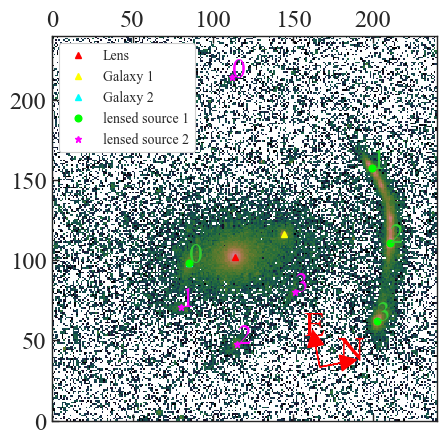

In [4]:
# %matplotlib ipympl
%matplotlib inline

# read-in the coordiante system of the exposure
ra_at_xy_0 = kwargs_data_F200LP['ra_at_xy_0']
dec_at_xy_0 = kwargs_data_F200LP['dec_at_xy_0']
transform_pix2angle = kwargs_data_F200LP['transform_pix2angle']
coords_F200LP = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)


# read-in the reduced cutout image
data_cutout = kwargs_data_F200LP['image_data']
numPix = len(data_cutout)
deltaPix = coords_F200LP.pixel_width
print('Pixel size: {:.2f} arcsec'.format(deltaPix))
print('numPix:', numPix)
# print('transform_pix2angle:', transform_pix2angle)

print('*'*20)

ax = plt.figure(figsize=(5, 5)).add_subplot(111)
ax.matshow(np.log10(data_cutout), origin='lower', cmap=cmap, vmin=-6, vmax=1.0) #v_min=-3,v_max= -0.2
ax.autoscale(False)

kwargs_pixel = {'nx': numPix, 'ny': numPix,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle} 

pixel_grid = PixelGrid(**kwargs_pixel)
plot_util.coordinate_arrows(ax, d=200, coords=pixel_grid, color='red', font_size=25, arrow_size=0.05)

lens_x_F200LP, lens_y_F200LP =113.73636, 101.67792  #113, 102   114.66136, 102.96184
lens_ra_F200LP, lens_dec_F200LP = coords_F200LP.map_pix2coord(lens_x_F200LP, lens_y_F200LP)
ax.plot(lens_x_F200LP, lens_y_F200LP, '^', color='red', label='Lens') 
print('Lens center:', lens_ra_F200LP, lens_dec_F200LP) 

print('*'*20)

gal1_x_F200LP, gal1_y_F200LP =144.16586, 116.44726 #144, 116   145.16586, 116.94726
gal1_ra_F200LP, gal1_dec_F200LP = coords_F200LP.map_pix2coord(gal1_x_F200LP, gal1_y_F200LP)
ax.plot(gal1_x_F200LP, gal1_y_F200LP, '^', color='yellow', label='Galaxy 1') 
print('Galaxy 1 center:', gal1_ra_F200LP, gal1_dec_F200LP)

gal2_x_F200LP, gal2_y_F200LP =84.9617, 98.3979 #144, 116   145.16586, 116.94726
gal2_ra_F200LP, gal2_dec_F200LP = coords_F200LP.map_pix2coord(gal2_x_F200LP, gal2_y_F200LP )
ax.plot(gal2_x_F200LP, gal2_y_F200LP, '^', color='cyan', label='Galaxy 2') 
print('Galaxy 2 center:', gal2_ra_F200LP, gal2_dec_F200LP)

print('*'*20)
#s1_x_img_pos,s1_y_img_pos =159.49841980975322, 86.19625327873504 # not final
#s1_x, s1_y =coords.map_pix2coord(s1_x_img_pos,s1_y_img_pos)
s1_x, s1_y=-0.9946517084153268, 1.141853220018103
s1_x_img_pos,s1_y_img_pos = coords_F200LP.map_coord2pix(s1_x, s1_y )
#ax.plot(s1_x_img_pos, s1_y_img_pos, '^', color='lime',markersize=10, label='Source 1')
print('Source 1 center:', s1_x, s1_y)
print('*'*20)

# estimate point source positions in pixel
im_pos_x = np.array([ 84.9617, 199.2906, 210.1870, 202.6028]) #84.9617,
im_pos_y = np.array([ 98.3979,157.3715, 110.8272, 62.1356]) #98.3979,

ra_image, dec_image = coords_F200LP.map_pix2coord(im_pos_x, im_pos_y)
ax.plot(im_pos_x, im_pos_y, 'o', color='lime',label='lensed source 1')

ra_image_1, dec_image_1 = copy.deepcopy(ra_image), copy.deepcopy(dec_image)

for i in range(len(im_pos_x)):
    ax.text(im_pos_x[i], im_pos_y[i], i, fontsize=20, color='limegreen')
    print('Image S1 center {}: {}, {}'.format(i, ra_image[i], dec_image[i]))

print('*'*20)
print('*'*20)

#s2_x_img_pos,s2_y_img_pos = 113.8880243857698, 129.71950917762942 # not final
#s2_x, s2_y =coords.map_pix2coord(s2_x_img_pos,s2_y_img_pos)
s2_x, s2_y= 0.6167336450339843, -0.20958171313143767
s2_x_img_pos,s2_y_img_pos = coords_F200LP.map_coord2pix( s2_x, s2_y)
#ax.plot(s2_x_img_pos,s2_y_img_pos, '^', color='magenta', label='Source 2',markersize=10)
print('Source 2 center:', s2_x, s2_y)
print('*'*20)

im_pos_x_s2=([112.0587, 80.1975, 115.1975, 150.9979 ])
im_pos_y_s2=([213.8998, 70.7983, 47.9979, 80.3970 ])

ra_image_s2, dec_image_s2 = coords_F200LP.map_pix2coord(im_pos_x_s2, im_pos_y_s2)
ax.plot(im_pos_x_s2, im_pos_y_s2, '*', color='magenta',label='lensed source 2')

ra_image_2, dec_image_2 = copy.deepcopy(ra_image_s2), copy.deepcopy(dec_image_s2)

for i in range(len(ra_image_2)):
    ax.text(im_pos_x_s2[i], im_pos_y_s2[i], i, fontsize=20, color='magenta')
    print('Image S2 center {}: {}, {}'.format(i, ra_image_s2[i], dec_image_s2[i]))

print('*'*20)

#print(coords.map_pix2coord(115.198,  47.998))

plt.legend(loc='upper left', fontsize=10, framealpha=1)
#plt.savefig(fname='DSPL1507.pdf', format='pdf')
plt.show()

Pixel size: 0.08 arcsec
numPix: 150
********************
********************
Lens center: -0.8294023773705237 -0.4695420413996334
Gal1 center: -0.39485199683448746 1.164841851292571
Gal2 center: -0.7158344298101684 -1.9130777388153974
********************
Source 1 center: -0.9946517084153268 1.141853220018103
********************
Image S1 center 0: -0.7158344298101684, -1.9130777388153974
Image S1 center 1: 1.087777899407675, 4.260816445991829
Image S1 center 2: -1.3006344591144519, 4.3514823462042616
Image S1 center 3: -3.6181050419045113, 3.514645359158428
pixel coordinates: [ 53.2326691  124.68862561 131.49864463 126.75826298], [61.653094   98.51099973 69.42075798 38.98854946] 

********************
Image S2 center 0: 4.694574513668902, 0.5189295049084397
Image S2 center 1: -2.0249943517481808, -2.4102535789679864
Image S2 center 2: -3.478016480968383, -0.9100397283898605
Image S2 center 3: -2.229425403868929, 1.1561651690498185
pixel coordinates: [70.16891011 50.25489826 72.129808

/var/folders/v5/068qyr6n1v16l5m5qs3sthxm0000gn/T/ipykernel_11081/2276443462.py:20: RuntimeWarning: invalid value encountered in log10
  ax.matshow(np.log10(data_cutout), origin='lower', cmap=cmap, vmin=-2, vmax=.5) #v_min=-3,v_max= -0.2


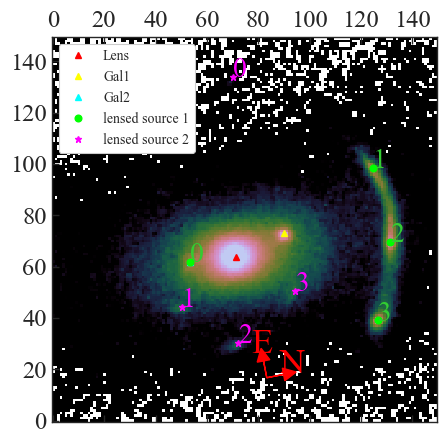

In [5]:
# %matplotlib ipympl
%matplotlib inline

# read-in the coordiante system of the exposure
ra_at_xy_0 = kwargs_data_F140W['ra_at_xy_0']
dec_at_xy_0 = kwargs_data_F140W['dec_at_xy_0']
transform_pix2angle = kwargs_data_F140W['transform_pix2angle']
coords_F140W = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)

# read-in the reduced cutout image
data_cutout = kwargs_data_F140W['image_data']
numPix = len(data_cutout)
deltaPix = coords_F140W.pixel_width
print('Pixel size: {:.2f} arcsec'.format(deltaPix))
print('numPix:', numPix)
# print('transform_pix2angle:', transform_pix2angle)
print('*'*20)

ax = plt.figure(figsize=(5, 5)).add_subplot(111)
ax.matshow(np.log10(data_cutout), origin='lower', cmap=cmap, vmin=-2, vmax=.5) #v_min=-3,v_max= -0.2
ax.autoscale(False)

kwargs_pixel = {'nx': numPix, 'ny': numPix,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle} 

pixel_grid = PixelGrid(**kwargs_pixel)
plot_util.coordinate_arrows(ax, d=100, coords=pixel_grid, color='red', font_size=25, arrow_size=0.05)

print('*'*20)
lens_ra_F140W, lens_dec_F140W=lens_ra_F200LP+kwargs_data_F140W['ra_shift'], lens_dec_F200LP+kwargs_data_F140W['dec_shift']
lens_x_F140W,lens_y_F140W=coords_F140W.map_coord2pix(lens_ra_F140W, lens_dec_F140W)
ax.plot(lens_x_F140W,lens_y_F140W, '^', color='red', label='Lens') 
print('Lens center:', lens_ra_F140W, lens_dec_F140W) 

gal1_ra_F140W, gal1_dec_F140W=gal1_ra_F200LP+kwargs_data_F140W['ra_shift'], gal1_dec_F200LP+kwargs_data_F140W['dec_shift']
gal1_x_F140W,gal1_y_F140W=coords_F140W.map_coord2pix(gal1_ra_F140W, gal1_dec_F140W)
ax.plot(gal1_x_F140W,gal1_y_F140W, '^', color='yellow', label='Gal1') 
print('Gal1 center:', gal1_ra_F140W, gal1_dec_F140W) 

gal2_ra_F140W, gal2_dec_F140W=gal2_ra_F200LP+kwargs_data_F140W['ra_shift'], gal2_dec_F200LP+kwargs_data_F140W['dec_shift']
gal2_x_F140W,gal2_y_F140W=coords_F140W.map_coord2pix(gal2_ra_F140W, gal2_dec_F140W)
ax.plot(gal2_x_F140W,gal2_y_F140W, '^', color='cyan', label='Gal2') 
print('Gal2 center:', gal2_ra_F140W, gal2_dec_F140W) 

print('*'*20)

s1_x, s1_y=-0.9946517084153268, 1.141853220018103
s1_x_img_pos,s1_y_img_pos = coords_F200LP.map_coord2pix(s1_x, s1_y )
#ax.plot(s1_x_img_pos, s1_y_img_pos, '^', color='lime',markersize=10, label='Source 1')
print('Source 1 center:', s1_x, s1_y)


print('*'*20)


im_pos_ra_F140W, im_pos_dec_F140W=ra_image+kwargs_data_F140W['ra_shift'], dec_image+kwargs_data_F140W['dec_shift']
im_pos_x_F140W, im_pos_y_F140W=coords_F140W.map_coord2pix(im_pos_ra_F140W, im_pos_dec_F140W)
ax.plot(im_pos_x_F140W, im_pos_y_F140W, 'o', color='lime',label='lensed source 1')
for i in range(len(im_pos_x_F140W)):
    ax.text(im_pos_x_F140W[i], im_pos_y_F140W[i], i, fontsize=20, color='limegreen')
    print('Image S1 center {}: {}, {}'.format(i, im_pos_ra_F140W[i], im_pos_dec_F140W[i]))

print('pixel coordinates: {}, {} \n'.format(im_pos_x_F140W, im_pos_y_F140W ))

print('*'*20)


im2_pos_ra_F140W, im2_pos_dec_F140W=ra_image_s2+kwargs_data_F140W['ra_shift'], dec_image_s2+kwargs_data_F140W['dec_shift']
im2_pos_x_F140W, im2_pos_y_F140W=coords_F140W.map_coord2pix(im2_pos_ra_F140W, im2_pos_dec_F140W)
ax.plot(im2_pos_x_F140W, im2_pos_y_F140W, '*', color='magenta',label='lensed source 2')

for i in range(len(im2_pos_ra_F140W)):
    ax.text(im2_pos_x_F140W[i], im2_pos_y_F140W[i], i, fontsize=20, color='magenta')
    print('Image S2 center {}: {}, {}'.format(i, im2_pos_ra_F140W[i], im2_pos_dec_F140W[i]))

print('pixel coordinates: {}, {} \n'.format(im2_pos_x_F140W, im2_pos_y_F140W))

print('*'*20)

plt.legend(loc='upper left', fontsize=10, framealpha=1)
#plt.savefig(fname='DSPL1507.pdf', format='pdf')
plt.show()

In [6]:
from astropy.cosmology import FlatLambdaCDM, wCDM
import astropy.units as u

cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3, Ob0=0.05)

#z_lens = 0.594
# Dominique and Lise claim 2.27 for the qso and 2.35 for the other blob.
#z_source_1 = 2.164
#z_source_2 = 2.6

z_l = 0.594
z_s1 = 2.163
z_s2 = 2.591 #2.5906

D_s1 = cosmo.angular_diameter_distance(z_s1).value
D_s2 = cosmo.angular_diameter_distance(z_s2).value
D_ls1 = cosmo.angular_diameter_distance_z1z2(z_l, z_s1).value
D_ls2 = cosmo.angular_diameter_distance_z1z2(z_l, z_s2).value

#cosmological scaling factor=deflection_scaling= 1/β
deflection_scaling = D_s1 / D_ls1 * D_ls2 / D_s2  
beta=1/deflection_scaling
print('Deflection angle rescale factor: {:.6f}'.format(deflection_scaling))
print('Beta:{:.6f}'.format(beta))




Deflection angle rescale factor: 1.060133
Beta:0.943278


### Define model for position modeling

### lens model intial parameter from GLEE conversions 

In [7]:
Dds1_s1=0.5954471482031719
Dds2_s2=0.6317719304697595
Ds1s2_s2=0.08978995477414305


q= 0.553 #b/a 
phi_GLEE=0.164 #theta in radians, measured from +x axis

#lenstronomy_axis_rot_from_x=np.arcsin(0.00954155/0.05)
lenstronomy_axis_rot_from_x=np.arcsin(0.00954155/0.08)

print("lenstronomy_axis_rot_from_x",lenstronomy_axis_rot_from_x)
phi_lenstro=(np.pi/2)+lenstronomy_axis_rot_from_x-phi_GLEE #angle from E to N direction
print("phi_lenstro",phi_lenstro)
phi=phi_lenstro #0.121238  
R_Eins_inf=5.445208
R_Eins=R_Eins_inf*Dds2_s2 #theta_e with scale, projected Einstein radius along major axis
Rcore=1.0000e-04  #1.0000e-04  #core radius, assumed too tiny
gam=0.5   #gam 


x,y=coords_F140W.map_pix2coord(5.73/0.05,  5.14/0.05)
print('lens centre= {:.3f}, {:.3f}'.format(x,y))

e1,e2 = lenstronomy.Util.param_util.phi_q2_ellipticity(phi, q) 
print('e1,e2={:0.3f},{:0.3f}'.format(e1,e2))

gamma_lens=2*gam+1
print('gamma={:0.3f}'.format(gamma_lens))

theta_Eins_spehrical=((2/(1+q))**(1/(gamma_lens-1)))*np.sqrt(q)*R_Eins
print('theta_E={:0.3f}'.format(theta_Eins_spehrical))

xs0,ys0=coords_F140W.map_pix2coord(6.177492/0.05, 4.991370/0.05)
print('source centre= {:.3f}, {:.3f}'.format(xs0,ys0))

shear_mag=0.199833
shear_phi_GLEE=1.354092
shear_phi_lenstro=(np.pi/2)+lenstronomy_axis_rot_from_x-shear_phi_GLEE
g1,g2=param_util.shear_polar2cartesian(phi=shear_phi_GLEE,gamma=shear_mag)
#g1,g2=param_util.shear_polar2cartesian(phi=shear_phi_lenstro,gamma=shear_mag)
psi_ext, gamma_ext = param_util.shear_cartesian2polar(g1, g2)
print("g1,g2:",g1,g2)
x_shear, y_shear=coords_F140W.map_pix2coord(0, 0)
print("shear centre=", x_shear, y_shear)

print("shear ext lenstronomy", psi_ext,gamma_ext)


lenstronomy_axis_rot_from_x 0.11955397205485381
phi_lenstro 1.5263502988497504
lens centre= 1.579, 3.534
e1,e2=-0.287,0.026
gamma=2.000
theta_E=3.295
source centre= 1.209, 4.191
g1,g2: -0.18135634163781797 0.08392321035772558
shear centre= -4.74480204403642 -7.034488715086257
shear ext lenstronomy 1.354092 0.199833


In [8]:
theta_Eins_spehrical=((2/(1+0.754))**(1/(1.966-1)))*np.sqrt(0.754)*2.406
print('theta_E={:0.3f}'.format(theta_Eins_spehrical))

theta_E=2.393


In [20]:
e1,e2 = lenstronomy.Util.param_util.phi_q2_ellipticity(0, 1) 
print('e1,e2={:0.3f},{:0.3f}'.format(e1,e2))

e1,e2=0.000,0.000


### Single plane

In [29]:
lens_model_list = ['EPL', 'SHEAR_GAMMA_PSI', 'SIS'] 
kwargs_lens_init =[{'theta_E': 3.780053376153156, 'gamma': 2, 'e1': -0.19201284387072598, 'e2': 0.039098708435327575,
                    'center_x': lens_ra_F140W, 'center_y':lens_dec_F140W}, 
                    {'gamma_ext': 0.14, 'psi_ext': 0.3715191655049447},                   
                    {'theta_E': 0.01, 'center_x': gal1_ra_F140W, 'center_y':gal1_dec_F140W}
                    ]

#lens_model_list = ['NFW_ELLIPSE_CSE', 'SHEAR_GAMMA_PSI', 'SIS', 'CHAMELEON'] 
lensModel = LensModel(lens_model_list=lens_model_list) 
#kwargs_lens_init =[{'Rs': 2.7764803243805676, 'alpha_Rs': 2.80679188340642, 'e1': -0.10282372262398363, 
#                    'e2': 0.01085956326185634, 'center_x': -0.8294023773705237, 'center_y': -0.4695420413996334}, 
#                   {'gamma_ext': 0.14262360368605162, 'psi_ext': 0.22408269151034546, 'ra_0': 0, 'dec_0': 0}, 
#                   {'theta_E': 0.3181225456357623, 'center_x':  -0.39485199683448746, 'center_y': 1.164841851292571}, 
#                   {'alpha_1': 1.1678502775786788, 'w_c': 0.039460425869688426, 'w_t': 1.222142326977086, 
#                   'e1': -0.15932330856686508, 'e2': 0.01811833169281849, 'center_x': -0.8294023773705237, 
#                    'center_y': -0.4695420413996334}
#                   ]

lensModel_s1 = LensModel(lens_model_list=lens_model_list)
solver4Point_s1 = Solver4Point(lensModel=lensModel_s1, solver_type='PROFILE_SHEAR')

kwargs_fit_s1, precision = solver4Point_s1.constraint_lensmodel(x_pos=im_pos_ra_F140W, y_pos=im_pos_dec_F140W, 
                                                                kwargs_list=kwargs_lens_init, xtol=1.49012e-12)
print("\n the re-fitted macro-model parameters are: ", kwargs_fit_s1)

kwargs_fit_init_use_last_best= kwargs_fit_s1

beta_x_new, beta_y_new = lensModel_s1.ray_shooting(im_pos_ra_F140W, im_pos_dec_F140W, kwargs_fit_s1)
print("\n The relative x position in the source plane (should match) is: ", beta_x_new - np.mean(beta_x_new))
print("\n The relative y position in the source plane (should match) is: ", beta_y_new - np.mean(beta_y_new))

print(beta_x_new,beta_y_new)
# we can now set a new estimate of the source position
beta_x_new = np.mean(beta_x_new)
beta_y_new = np.mean(beta_y_new)
print("\n new mean source pos",beta_x_new,beta_y_new)


 the re-fitted macro-model parameters are:  [{'theta_E': 3.7800532649415985, 'gamma': 2, 'e1': -0.19205035778911247, 'e2': 0.03913617623321567, 'center_x': -0.8719985573591365, 'center_y': -0.4754244002028463}, {'gamma_ext': 0.14, 'psi_ext': 0.3716099765653795}, {'theta_E': 0.01, 'center_x': -0.39485199683448746, 'center_y': 1.164841851292571}]

 The relative x position in the source plane (should match) is:  [-3.99680289e-15  8.88178420e-16  1.11022302e-15  1.77635684e-15]

 The relative y position in the source plane (should match) is:  [ 1.11022302e-15  0.00000000e+00  4.44089210e-16 -8.88178420e-16]
[-1.06192033 -1.06192033 -1.06192033 -1.06192033] [1.43621242 1.43621242 1.43621242 1.43621242]

 new mean source pos -1.0619203294501656 1.436212417216439


In [30]:
#Re=2
alpha_x, alpha_y = lensModel_s1.alpha(1, 1, kwargs_fit_s1)
alpha_x, alpha_y
alpha=np.sqrt(alpha_x**2 +alpha_y**2)
print(alpha)

3.965206743009848


In [31]:
lensEquationSolver_new = LensEquationSolver(lensModel=lensModel_s1) #gives img positions given lens model and source
ra_image_s1_pred, dec_image_s1_pred = lensEquationSolver_new.image_position_from_source(kwargs_lens=kwargs_fit_s1, sourcePos_x=beta_x_new, sourcePos_y=beta_y_new, min_distance=0.01, search_window=100, precision_limit=10**(-10), num_iter_max=1000)
print("\n predicted imag pos based on lens init para",ra_image_s1_pred, dec_image_s1_pred) 



 predicted imag pos based on lens init para [ 1.0877779  -3.61810504 -1.30063446 -0.71583443] [ 4.26081645  3.51464536  4.35148235 -1.91307774]


### Multi-plane mode position modeling

In [51]:
# specify redshifts of deflectors #
#redshift_list = [0.594, 0.594, 0.594, 0.594,0.594, 2.163] # 

# specify source redshift #
#z_source = 2.591

#lens_model_list_mp =  ['NFW_ELLIPSE_CSE', 'SHEAR_GAMMA_PSI', 'SIS','DOUBLE_CHAMELEON','SIE','EPL'] #'SIE',
#kwargs_lens_init =[{'Rs': 3.521581477004546, 'alpha_Rs': 3.4382337345561087, 
#                    'e1': -0.3559868048835723, 'e2': -0.02678843063525647, 
#                    'center_x': -0.8072782025272569, 'center_y': -0.4854830831979301}, 
#                   {'gamma_ext': 0.12371273322649166, 'psi_ext': 0.3378508275396008, 
#                    'ra_0': 0, 'dec_0': 0}, 
#                   {'theta_E': 0.011456483315086738, 
#                    'center_x': -0.4139371828464453, 'center_y': 1.1622334485335695}, 
#                   {'alpha_1': 0.17154599333384643, 'ratio': 1.2109211747713948, 
#                    'w_c1': 0.9621550690734898, 'w_t1': 0.809815106947698, 
#                    'e11': -0.4317124945007528, 'e21': 0.14379691683658466, 
#                    'w_c2': 0.0013252844467266161, 'w_t2': 2.2462391195982474,
#                    'e12': -0.2809576665631261, 'e22': -0.01787958014276973,
#                    'center_x': -0.8072782025272569, 'center_y': -0.4854830831979301},
#                    {'theta_E': 0.1, 'e1': 0.4991792259730781, 'e2': 0.499878878125105, 
#                     'center_x': -0.7345015530690363, 'center_y': -1.948908864100021},
#                   {'theta_E': 0.2, 'gamma': 2,     
#                    'e1': 0.1338966016029039, 'e2': -0.49223342843833934, 
#                    'center_x': -1.1002051978979777, 'center_y': 2.090894590698304} #0.010080918982363391
#                  ]
redshift_list = [0.594, 0.594, 0.594, 0.594, 2.163]
z_source = 2.591
lens_model_list_mp =  ['EPL', 'SHEAR_GAMMA_PSI', 'SIS','SIE','EPL'] #'SIE',
kwargs_lens_init =[{'theta_E': 3.4575777240870047, 
  'gamma': 2.1514463909833017, 
  'e1': -0.4545330043483049,
  'e2': -0.00842067369169645,  
  'center_x': -0.8065128068114047, 
  'center_y': -0.4863621404114578},
                   
 {'gamma_ext': 0.19, #0.13148685985171998,
  'psi_ext': 0.40986584465246867 
   },
 {'theta_E': 0.2,
  'center_x': -0.4111485552100165,
  'center_y': 1.1452236610042401},
 
 {'theta_E': 0.05,
  'e1': 0.4999959404546784,
  'e2': 0.029470580388037116,
  'center_x': -0.7293171932109231,
  'center_y': -1.8629524177334764},
                   
{'theta_E': 0.2,
  'gamma': 2,
  'e1': -0.05577983510224609,
  'e2': -0.29559310198051836,
  'center_x': -1.0692479921221822,
  'center_y': 1.6751415900688214}
                  ]



lensModel_mp = LensModel(lens_model_list=lens_model_list_mp, z_source=z_source, lens_redshift_list=redshift_list, cosmo= cosmo, multi_plane=True) #lens_model_list_simple[:2] for slicing
solver4Point_mp = Solver4Point(lensModel=lensModel_mp, solver_type='PROFILE_SHEAR') #PROFILE_SHEAR PROFILE

kwargs_fit_mp, precision = solver4Point_mp.constraint_lensmodel(x_pos=im2_pos_ra_F140W, y_pos=im2_pos_dec_F140W, kwargs_list=kwargs_lens_init, xtol=1.49012e-12)
print("\n the re-fitted macro-model parameters are: ", kwargs_fit_mp)

kwargs_fit_init_use_last_best_mp= kwargs_fit_mp
# check whether this simpler solution obeys the lens equation
#lensModel_mp2 = LensModel(lens_model_list_mp[:n]) #nope not same as above one for multiplane
#beta_x_new, beta_y_new = lensModel_mp2.ray_shooting(ra_image_2, dec_image_2, kwargs_fit_mp[:n])

beta_x_new_s2, beta_y_new_s2 = lensModel_mp.ray_shooting(im2_pos_ra_F140W, im2_pos_dec_F140W, kwargs_fit_mp)
print("\n The relative x position in the source plane (should match) is: ", beta_x_new_s2 - np.mean(beta_x_new_s2))
print("\n The relative y position in the source plane (should match) is: ", beta_y_new_s2 - np.mean(beta_y_new_s2))

# we can now set a new estimate of the source position
beta_x_new_s2 = np.mean(beta_x_new_s2)
beta_y_new_s2 = np.mean(beta_y_new_s2)
print("\n new mean source pos",beta_x_new_s2,beta_y_new_s2)


 the re-fitted macro-model parameters are:  [{'theta_E': 3.4925606480772675, 'gamma': 2.1514463909833017, 'e1': -0.733517822754062, 'e2': 0.14910334180654047, 'center_x': -1.307505766707267, 'center_y': -0.5041060916464545}, {'gamma_ext': 0.19, 'psi_ext': 0.4978342208756371}, {'theta_E': 0.2, 'center_x': -0.4111485552100165, 'center_y': 1.1452236610042401}, {'theta_E': 0.05, 'e1': 0.4999959404546784, 'e2': 0.029470580388037116, 'center_x': -0.7293171932109231, 'center_y': -1.8629524177334764}, {'theta_E': 0.2, 'gamma': 2, 'e1': -0.05577983510224609, 'e2': -0.29559310198051836, 'center_x': -1.0692479921221822, 'center_y': 1.6751415900688214}]

 The relative x position in the source plane (should match) is:  [-9.21485110e-15  1.55431223e-15  5.32907052e-15  2.44249065e-15]

 The relative y position in the source plane (should match) is:  [-6.93889390e-16  5.96744876e-15 -1.02695630e-15 -4.27435864e-15]

 new mean source pos 0.6885601295532996 -0.13454256608984524


In [18]:

lensEquationSolver_s2 = LensEquationSolver(lensModel=lensModel_mp) #gives img positions given lens model and source
ra_image_2_pred, dec_image_2_pred = lensEquationSolver_s2.image_position_from_source(kwargs_lens=kwargs_fit_mp, sourcePos_x=0.7121332500469968, sourcePos_y=-0.10778060768663678, min_distance=0.01, search_window=10, precision_limit=10**(-10), num_iter_max=1000)
print("\n predicted imag pos based on lens init para",ra_image_2_pred, dec_image_2_pred) 
#x_image_new, y_image_new = lensEquationSolver_new.image_position_from_source(kwargs_lens=kwargs_fit_mp[:n], sourcePos_x=beta_x_new, sourcePos_y=beta_y_new, min_distance=0.01, search_window=100, precision_limit=10**(-10), num_iter_max=1000)
#print("\n predicted imag pos",x_image_new, y_image_new) 


 predicted imag pos based on lens init para [ 4.69457451 -3.47801648 -2.2294254  -2.02499435] [ 0.5189295  -0.91003973  1.15616517 -2.41025358]


### Testing model for source1 (in multiplane mode without source1 as lens)

In [40]:
lens_model_list_mp[:4]

['NFW_ELLIPSE_CSE', 'SHEAR_GAMMA_PSI', 'SIS', 'DOUBLE_CHAMELEON']

In [41]:
lensModel_mp1 = LensModel(lens_model_list=lens_model_list_mp[:4], 
                          z_source=2.163, lens_redshift_list=redshift_list[:4], 
                          cosmo= cosmo, multi_plane=True) 
lensEquationSolver_s1 = LensEquationSolver(lensModel=lensModel_mp1) 

In [42]:
beta_x_new_s1, beta_y_new_s1 = lensModel_mp1.ray_shooting(im_pos_ra_F140W, im_pos_dec_F140W, kwargs_lens_init[:4])
print(beta_x_new_s1, beta_y_new_s1)
#beta_x_new_s1_cuspy, beta_y_new_s1_cuspy = lensModel_mp1.ray_shooting(ra_image_1_cuspy, dec_image_1_cuspy, 
#                                                                      kwargs_lens_init[:5])
#print(beta_x_new_s1_cuspy, beta_y_new_s1_cuspy)


[-0.69465845 -1.21645887 -1.05622135 -0.96473606] [0.20053642 1.93524282 1.90080333 1.95852822]


In [22]:
np.mean([-1.03734582, -0.99781908, -1.15330112])

-1.0628220066666667

In [21]:
np.mean([2.08229196, 2.18886427,2.22963084])

2.166929023333333

In [43]:
ra_image_1_pred1, dec_image_1_pred1 = lensEquationSolver_s1.image_position_from_source(
                                        kwargs_lens=kwargs_lens_init[:4], 
                                        sourcePos_x=-1.1002051978979777,
                                        sourcePos_y=2.090894590698304, 
                                        min_distance=0.01, search_window=10, 
                                        precision_limit=10**(-10), num_iter_max=1000)
print("\n predicted imag pos based on lens init para",ra_image_1_pred1, dec_image_1_pred1) 


 predicted imag pos based on lens init para [-3.87407199  1.44062876 -1.23785073] [3.54403997 4.34237168 4.54198267]


In [16]:
lensEquationSolver_s1 = LensEquationSolver(lensModel=lensModel_mp[:4]) #gives img positions given lens model and source
ra_image_1_pred, dec_image_1_pred = lensEquationSolver_s1.image_position_from_source(kwargs_lens=kwargs_fit_mp[:4], sourcePos_x=-1.0853965433333335, sourcePos_y=2.3738755533333333, min_distance=0.01, search_window=100, precision_limit=10**(-10), num_iter_max=1000)
print("\n predicted imag pos based on lens init para",ra_image_1_pred, dec_image_1_pred) 

TypeError: 'LensModel' object is not subscriptable

### Testing model from extended modeling

In [19]:
lensEquationSolver_s1_new = LensEquationSolver(lensModel=lensModel_from_SB_model) #gives img positions given lens model and source
x_image_s1_new, y_image_s1_new = lensEquationSolver_s1_new.image_position_from_source(kwargs_lens=kwargs_lens_from_SB_model, sourcePos_x= -1.9095784321060927, sourcePos_y=1.6810103387762296, min_distance=0.01, search_window=100, precision_limit=10**(-10), num_iter_max=1000)
print("\n predicted imag pos",x_image_s1_new, y_image_s1_new) 


 predicted imag pos [-1.99821339 -1.9842464 ] [1.78413486 1.76611919]


In [ ]:
beta_x_s1_pred, beta_y_s1_pred = lensModel_from_SB_model.ray_shooting(x_image_s1_new, y_image_s1_new, kwargs_lens_from_SB_model)
print(beta_x_s1_pred, beta_y_s1_pred)
print("\n The relative x position in the source plane (should match) is: ", beta_x_s1_pred - np.mean(beta_x_s1_pred))
print("\n The relative y position in the source plane (should match) is: ", beta_y_s1_pred - np.mean(beta_y_s1_pred))
beta_x_s1_new=np.mean(beta_x_s1_pred)
beta_y_s1_new=np.mean(beta_y_s1_pred)
print(beta_x_s1_new,beta_y_s1_new)

In [46]:
lensEquationSolver_s1_new = LensEquationSolver(lensModel=lensModel_s1) #gives img positions given lens model and source
x_image_s1_new, y_image_s1_new = lensEquationSolver_s1_new.image_position_lenstronomy(kwargs_lens=kwargs_fit_mp, sourcePos_x=-1.0430753920501783, sourcePos_y=1.4400677916553473, min_distance=0.01, search_window=100, precision_limit=10**(-10), num_iter_max=1000)


In [58]:
theta_E_lens_s2=3.674295847466711/((1017.761505801248*1650.4225584983337)/(1709.2390296476467*1042.690645873332))
print(theta_E_lens_s2)
theta_E_gal_s2=0.1/((1017.761505801248*1650.4225584983337)/(1709.2390296476467*1042.690645873332))
print(theta_E_gal_s2)

3.8984433592064347
0.10610042089817741


In [22]:
#source 1
x_S1_image_new, y_S1_image_new=coords.map_coord2pix(x_image_s1_new, y_image_s1_new)
x_source1_new_ra,y_source1_new_dec =coords.map_coord2pix(beta_x_s1_new, beta_y_s1_new)

In [27]:
#source2
x_source_new_ra=beta_x_new
y_source_new_dec=beta_y_new 
x_source_new,y_source_new=coords.map_coord2pix(x_source_new_ra,y_source_new_dec) 
print("source position in pix", x_source_new,y_source_new) 
print("source position in arcsec", 0.05*x_source_new,0.05*y_source_new)
#x_S2_image_new, y_S2_image_new=coords.map_coord2pix(x_image_new, y_image_new) 
#print("Lensed source 2 positions", x_S2_image_new, y_S2_image_new)


source position in pix 137.2095524941663 114.85092972633034
source position in arcsec 6.860477624708316 5.742546486316517


In [28]:

#lens_x_new,lens_y_new=coords.map_coord2pix(kwargs_fit_simple[0]['center_x'], kwargs_fit_simple[0]['center_y'])
#pert_x_new,pert_y_new=coords.map_coord2pix(kwargs_fit_simple[2]['center_x'], kwargs_fit_simple[2]['center_y'])

lens_x_new,lens_y_new=coords.map_coord2pix(kwargs_fit_mp[0]['center_x'], kwargs_fit_mp[0]['center_y'])
pert_x_new,pert_y_new=coords.map_coord2pix(kwargs_fit_mp[2]['center_x'], kwargs_fit_mp[2]['center_y'])
src1_x_new,src1_y_new=coords.map_coord2pix(kwargs_fit_mp[3]['center_x'], kwargs_fit_mp[3]['center_y'])
print(lens_x_new,lens_y_new)
print(pert_x_new,pert_y_new)
print(src1_x_new,src1_y_new)

114.56226954393246 100.92435256599937
145.14274578762178 116.96218362962559
152.25441480204563 105.01828934382223


### Plotting new positions

/var/folders/v5/068qyr6n1v16l5m5qs3sthxm0000gn/T/ipykernel_2958/3287551400.py:3: RuntimeWarning: invalid value encountered in log10
  ax.matshow(np.log10(data_cutout), origin='lower', cmap=cmap, vmin=-3, vmax=1.)


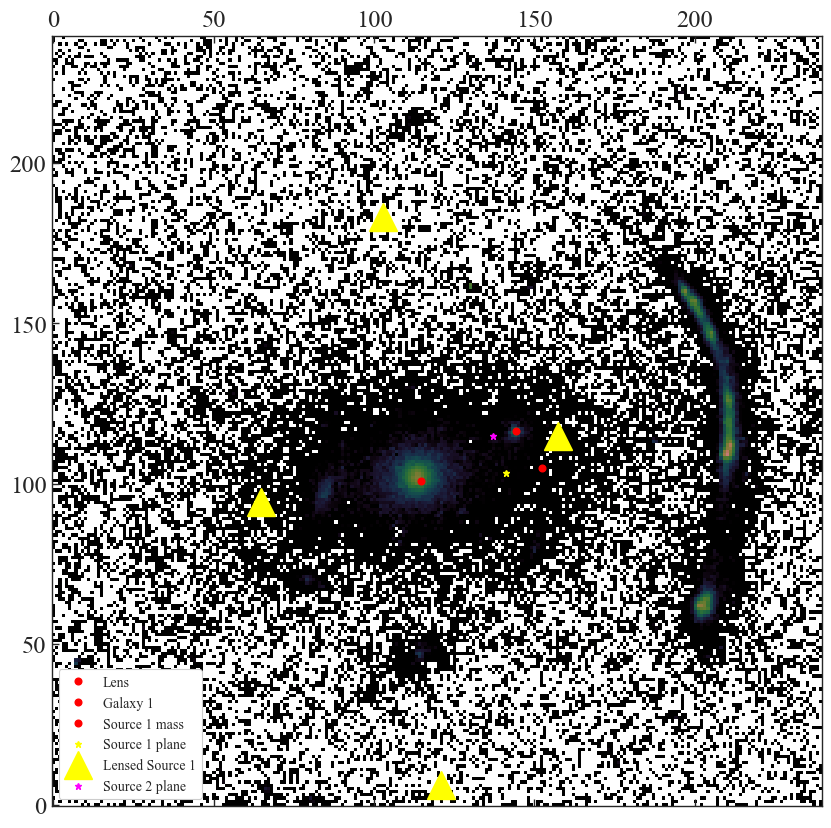

In [26]:
data_cutout = kwargs_data_F200LP['image_data']
ax = plt.figure(figsize=(10, 10)).add_subplot(111)
ax.matshow(np.log10(data_cutout), origin='lower', cmap=cmap, vmin=-3, vmax=1.)
ax.autoscale(False)

ax.plot(lens_x_new,lens_y_new, 'o', color='red', label='Lens') 
ax.plot(gal1_x_F200LP, gal1_y_F200LP, 'o', color='red', label='Galaxy 1') 
ax.plot(src1_x_new,src1_y_new, 'o', color='red', label='Source 1 mass')
#ax.plot(pert_x_new,pert_y_new, '*', color='red', label='perturber') 

#original observed position
#ax.plot(im_pos_x, im_pos_y, 'o', color='lime',label='lensed source 1')
#ax.plot(im_pos_x_s2, im_pos_y_s2, 'o', color='magenta',label='lensed source 2')

#ax.plot(x_pos11, y_pos11, 'o', color='magenta',label='lensed source 2') #from point source
#ax.plot(x_pos22, y_pos22, 'o', color='magenta',label='lensed source 2') #from point source

#ax.plot(beta_x_new,beta_y_new, '^', color='green', label='Source 1',markersize=20)

#ax.plot(xs,ys, '^', color='yellow', label='Source 1 predicted')


ax.plot(x_source1_new_ra,y_source1_new_dec, '*', color='yellow', label='Source 1 plane')
ax.plot(x_S1_image_new, y_S1_image_new, '^', markersize=20, color='yellow',label='Lensed Source 1')

ax.plot(x_source_new,y_source_new, '*', color='magenta', label='Source 2 plane')
#ax.plot(x_S2_image_new, y_S2_image_new, '^', color='magenta', label='Lensed Source 2') 


plt.legend(loc=3,fontsize=10, framealpha=1)
plt.show()

/var/folders/v5/068qyr6n1v16l5m5qs3sthxm0000gn/T/ipykernel_18118/4232269132.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


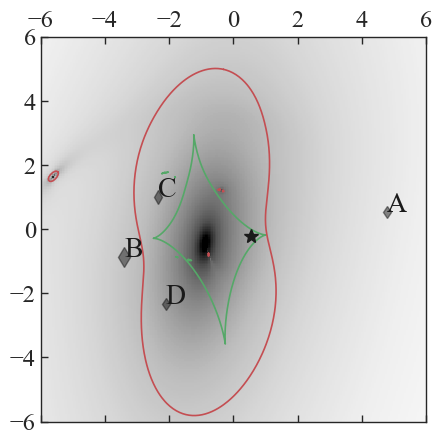

In [70]:
from lenstronomy.Plots import lens_plot
f, axex = plt.subplots(1, 1, figsize=(10, 5), sharex=False, sharey=False)
#lens_plot.lens_model_plot(axex[0], lensModel=lensModel, kwargs_lens=kwargs_lens, sourcePos_x=beta_ra, sourcePos_y=beta_dec, point_source=True, with_caustics=True, fast_caustic=True, coord_inverse=False)
lens_plot.lens_model_plot(axex, lensModel=lensModel_mp, kwargs_lens=kwargs_fit_mp, numPix=240,deltaPix=0.05, sourcePos_x=beta_x_new, sourcePos_y=beta_y_new, point_source=True, with_caustics=True, fast_caustic=True, coord_inverse=False)
f.show()

In [78]:
import pickle
file = open("output.pkl",'rb')
result=pickle.load(file)
file.close()
result

{'re_fitted_macro_model_parameters': [{'theta_E': 3.20242850237448,
   'gamma': 2,
   'e1': -0.5381595622974561,
   'e2': 0.07629776547975138,
   'center_x': -1.1219215052506832,
   'center_y': -0.5600331668592048},
  {'gamma_ext': 0.15, 'psi_ext': 0.523299843999611},
  {'theta_E': 0.3, 'center_x': -0.389, 'center_y': 1.205}],
 'relative_x_position_source_plane': array([-1.79944948e-12,  2.21822560e-12, -1.83142390e-12,  1.41264778e-12]),
 'relative_y_position_source_plane': array([-6.16645623e-13, -6.95027369e-13, -4.90191221e-13,  1.80186421e-12]),
 'new_mean_source_pos': (0.559755901282097, -0.22220471074039636)}

In [76]:
coords.radec_at_xy_0

(-4.744741972869315, -7.034535113272021)

[array([ 4.77866811, -3.39462171, -2.34897352, -2.10864604])] [array([ 0.53673127, -0.87403701,  1.0119631 , -2.33673562])]


[array([ 4.68447451, -2.03509435, -3.48811648, -2.2395254 ])] [array([ 0.5062295 , -2.42295358, -0.92273973,  1.14346517])]
